In [1]:
import csv
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from random import shuffle
from sklearn.pipeline import Pipeline

In [2]:
# load data from a file and append it to the rawData
def loadData(path, Text=None):
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader, None)  # skip the headers        
        for line in reader:
            (Id, Text, Label, Rating, Verified) = parseReview(line)
            rawData.append((Id, Text, Label, Rating, Verified))

In [3]:
# QUESTION 1
def parse_label(label):
    if label == '__label2__':
        return 'real'
    else:
        return 'fake'    

def parse_verification(label):
    if label == 'N':
        return 0
    else:
        return 1      

# Convert line from input file into an id/text/label tuple
def parseReview(reviewLine):
    # Should return a triple of an integer, a string containing the review, and a string indicating the label
    return (reviewLine[0], \
            reviewLine[8] + ' ' + reviewLine[7], \
            parse_label(reviewLine[1]), \
            reviewLine[2], \
            parse_verification(reviewLine[3]))
        

In [4]:
from __future__ import unicode_literals

import re, string, nltk
from nltk.corpus.reader.wordnet import NOUN
from nltk.corpus import wordnet
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop = set(stopwords.words('english'))
s = nltk.stem.SnowballStemmer('english')
l = WordNetLemmatizer()
translator=str.maketrans('','',string.punctuation)

# Input: a string of one review
def preProcess(text):  
    text = re.sub(r"(\w)([.,;:!-?'\"”\)])", r"\1 \2", text)
    text = re.sub(r"([.,;:!-?'\"“\(])(\w)", r"\1 \2", text)
    text = re.sub(r"<[^>]*>", "", text)    
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.translate(translator)
    text = text.lower()    
    tokens = word_tokenize(text)
    tokens = [l.lemmatize(t) for t in tokens]
#     tokens = [s.stem(t) for t in tokens]    
    tokens = [t for t in tokens if t not in stop]
    return tokens

In [5]:
# QUESTION 2
featureDict = {} # A global dictionary of features

def toFeatureVector(tokens, rating, verified):
    # Should return a dictionary containing features as keys, and weights as values
    v = {}
    for t in tokens:
        try:
            featureDict[t] += 1
        except KeyError:            
            featureDict[t] = 1
        try:
            v[t] += (1.0/len(tokens))
        except KeyError:
            v[t] = (1.0/len(tokens))
    #Adding additional features to the vectors
    v['Rating'] = rating
    v['Verified'] = verified    
    return v

In [6]:
# TRAINING AND VALIDATING OUR CLASSIFIER
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(trainData)

In [7]:
# QUESTION 3

def crossValidate(dataset, folds):
    shuffle(dataset)
    predictions = []
    ground_truth = []
    foldSize = int(len(dataset)/folds)
    #preProcess and tokenize once!
    dataset = [(t[0], preProcess(t[1]), t[2], t[3], t[4]) for t in dataset]
    dataset = [(t[0], toFeatureVector(t[1], t[3], t[4]), t[2]) for t in dataset]    
    
    for i in range(0,len(dataset), foldSize):
        trainFolds = dataset[:i] + dataset[i+foldSize:]        
        validationFold = dataset[i: i+foldSize]
        
        training_set = [(t[1], t[2]) for t in trainFolds]
        classifier = trainClassifier(training_set)
        validation_set = [(t[0], t[1]) for t in validationFold]
        predictions.append(predictLabels(validationFold, classifier))
        ground_truth.append([ l[2] for l in validationFold])
        
    return ground_truth, predictions

In [8]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predictLabels(reviewSamples, classifier):
    return classifier.classify_many(map(lambda t: t[1], reviewSamples))

def predictLabel(reviewSample, classifier):
    return classifier.classify(toFeatureVector(preProcess(reviewSample)))

In [9]:
def flatten(lst):
    for el in lst:
        if isinstance(el, list):
            yield from el
        else:
            yield el

In [10]:
# MAIN
import time
start_time = time.time()

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# loading reviews
rawData = []          # the filtered data from the dataset file (should be 21000 samples)
trainData = []        # the training data as a percentage of the total dataset (currently 80%, or 16800 samples)

# the output classes
fakeLabel = 'fake'
realLabel = 'real'

# references to the data files
reviewPath = 'amazon_reviews.txt'

## Do the actual stuff
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData" % (len(rawData), len(trainData)),
      "Preparing the dataset...",sep='\n')
loadData(reviewPath) 
print("Now %d rawData, %d trainData" % (len(rawData), len(trainData)),
      "Preparing the dataset...",sep='\n')

ground_truth, predictions = crossValidate(rawData, 10)
ground_truth = list(flatten(ground_truth))
predictions = list(flatten(predictions))

# We print the number of training samples and the number of features
print("Now %d rawData, %d trainData" % (len(rawData), len(trainData)),
      "Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')
print('Accuracy: ' + str(round(100*accuracy_score(ground_truth, predictions), 2)))
print(metrics.classification_report(ground_truth, predictions))

print("--- %s seconds ---" % (time.time() - start_time))

Now 0 rawData, 0 trainData
Preparing the dataset...
Now 21000 rawData, 0 trainData
Preparing the dataset...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Now 21000 rawData, 0 trainData
Training Samples: 
0
Features: 
29990
Accuracy: 79.0
             precision    recall  f1-score   support

       fake       0.81      0.75      0.78     10500
       real       0.77      0.83      0.80     10500

avg / total       0.79      0.79      0.79     21000

--- 44.12338995933533 seconds ---


In [11]:
#Data Exploration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [12]:
#Let's add some more columns and make some a bit more readable
names = ['doc_id', 'label', 'rating', 'verified_purchase', \
         'pr_category', 'pr_id', 'pr_title', 'review_title', 'review_text']
data = pd.read_csv('amazon_reviews.txt', skiprows=[0], names=names, sep='\t')
data['verified_purchase'] = data['verified_purchase'].apply(lambda x: 1 if x=='Y' else 0)
data['label'] = data['label'].apply(lambda x: 'real' if x=='__label2__' else 'fake')
data['review_text_length'] = data.apply(lambda row: len(row.review_text), axis=1)
data['review_title_length'] = data.apply(lambda row: len(row.review_title), axis=1)

REAL REVIEWS


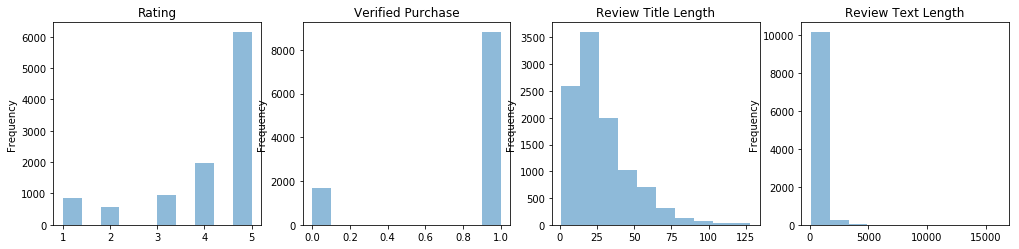

FAKE REVIEWS


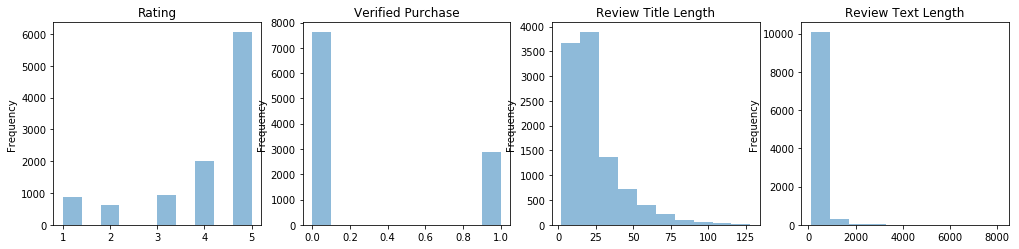

In [13]:
#To start the real reviews, let's look at some some statistics
real_data = data[data['label']== 'real'] 
fake_data = data[data['label']== 'fake'] 
plt.figure(figsize=(35,35))

print('REAL REVIEWS')
# print('Rating stats:')
# print(data['rating'].describe())
plt.subplot(8,8,1)
plt.title('Rating')
real_data['rating'].plot.hist(alpha=0.5)


# print('Verification stats:')
# print(data['verified_purchase'].describe())
plt.subplot(8,8,2)
plt.title('Verified Purchase')
real_data['verified_purchase'].plot.hist(alpha=0.5)


# print('Title length stats:')
# print(data['review_title_length'].describe())
plt.subplot(8,8,3)
plt.title('Review Title Length')
real_data['review_title_length'].plot.hist(alpha=0.5)


# print('Review length stats:')
# print(data['review_text_length'].describe())
plt.subplot(8,8,4)
plt.title('Review Text Length')
real_data['review_text_length'].plot.hist(alpha=0.5)

plt.show()

plt.figure(figsize=(35,35))
print('FAKE REVIEWS')

# print('Rating stats:')
# print(data['rating'].describe())
plt.subplot(8,8,1)
plt.title('Rating')
fake_data['rating'].plot.hist(alpha=0.5)


# print('Verification stats:')
# print(data['verified_purchase'].describe())
plt.subplot(8,8,2)
plt.title('Verified Purchase')
fake_data['verified_purchase'].plot.hist(alpha=0.5)


# print('Title length stats:')
# print(data['review_title_length'].describe())
plt.subplot(8,8,3)
plt.title('Review Title Length')
fake_data['review_title_length'].plot.hist(alpha=0.5)


# print('Review length stats:')
# print(data['review_text_length'].describe())
plt.subplot(8,8,4)
plt.title('Review Text Length')
fake_data['review_text_length'].plot.hist(alpha=0.5)

plt.show()

In [14]:
#And now to get some stats on the tokens of the reviews
import nltk
def averageLen(lst):
    lengths = [len(i) for i in lst]
    return 0 if len(lengths) == 0 else (float(sum(lengths)) / len(lengths)) 

stop_words = set(stopwords.words('english'))

#Tokenising the review inthe dataframe, getting the count of tokens and stopwords
data['tokenized_review'] = data.apply(lambda row: re.sub(r"(\w)([.,;:!-?'\"”\)])", r"\1 \2", row['review_text']), axis=1)
data['tokenized_review'] = data.apply(lambda row: re.sub(r"([.,;:!-?'\"“\(])(\w)", r"\1 \2", row['review_text']), axis=1)
data['tokenized_review'] = data.apply(lambda row: re.sub(r"<[^>]*>", "", row['review_text']), axis=1)
data['tokenized_review'] = data.apply(lambda row: nltk.word_tokenize(row['review_text'].lower()), axis=1)
data['tokenized_review'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t.isalpha()], axis=1)
# data['tokenized_review'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t not in stopwords.words('english')], axis=1)
data['tokenized_review'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t not in stop_words], axis=1)
# data['tokenized_review_stop'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t in stopwords.words('english')], axis=1)
data['num_tokens'] = data.apply(lambda row: len(row['tokenized_review']), axis=1)
data['avg_len_tokens'] = data.apply(lambda row: averageLen(row['tokenized_review']), axis=1)
# data['num_stopwords'] = data.apply(lambda row: len(row['tokenized_review_stop']), axis=1)

REAL REVIEWS


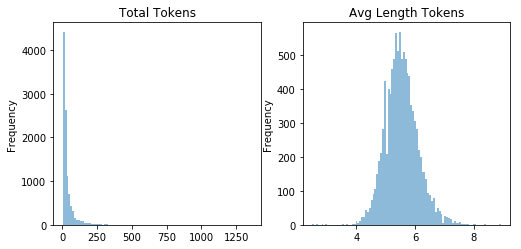

FAKE REVIEWS


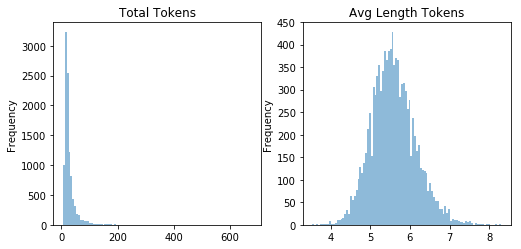

Real Data Avg Token Length: 5.54
Fake Data Avg Token Length: 5.59
Real Data Median Token Length: 5.5
Fake Data Median Token Length: 5.55
Real Data StDev Token Length: 0.55
Fake Data StDev Token Length: 0.56


In [15]:
real_data = data[data['label']== 'real'] 
fake_data = data[data['label']== 'fake'] 

plt.figure(figsize=(35,35))
print('REAL REVIEWS')
plt.subplot(8,8,1)
plt.title('Total Tokens')
real_data['num_tokens'].plot.hist(alpha=0.5, bins=100)


# print('Verification stats:')
# print(data['verified_purchase'].describe())
plt.subplot(8,8,2)
plt.title('Avg Length Tokens')
real_data['avg_len_tokens'].plot.hist(alpha=0.5, bins=100)

plt.show()

plt.figure(figsize=(35,35))
print('FAKE REVIEWS')
plt.subplot(8,8,1)
plt.title('Total Tokens')
fake_data['num_tokens'].plot.hist(alpha=0.5, bins=100)


# print('Verification stats:')
# print(data['verified_purchase'].describe())
plt.subplot(8,8,2)
plt.title('Avg Length Tokens')
fake_data['avg_len_tokens'].plot.hist(alpha=0.5, bins=100)

plt.show()

print('Real Data Avg Token Length: ' + str(round(real_data['avg_len_tokens'].mean(axis=0), 2)))
print('Fake Data Avg Token Length: ' + str(round(fake_data['avg_len_tokens'].mean(axis=0), 2)))

print('Real Data Median Token Length: ' + str(round(real_data['avg_len_tokens'].median(axis=0), 2)))
print('Fake Data Median Token Length: ' + str(round(fake_data['avg_len_tokens'].median(axis=0), 2)))

print('Real Data StDev Token Length: ' + str(round(real_data['avg_len_tokens'].std(axis=0), 2)))
print('Fake Data StDev Token Length: ' + str(round(fake_data['avg_len_tokens'].std(axis=0), 2)))

In [16]:
import gensim, collections, itertools
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

real_data = data[data['label']== 'real'] 
fake_data = data[data['label']== 'fake'] 

print('REAL REVIEWS:')
real_data_corpus = list(real_data['tokenized_review'])
dictionary = Dictionary(real_data_corpus)
corpus = [dictionary.doc2bow(review) for review in real_data_corpus]

# Create the defaultdict: total_word_count
total_word_count = collections.defaultdict(int)

for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count

# Create a sorted list from the defaultdict: sorted_word_count
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

# Print the top 25 words across all documents alongside the count
for word_id, word_count in sorted_word_count[:25]:
    print(word_id, dictionary.get(word_id), word_count)

print('FAKE REVIEWS:')
fake_data_corpus = list(fake_data['tokenized_review'])
dictionary = Dictionary(fake_data_corpus)
corpus = [dictionary.doc2bow(review) for review in fake_data_corpus]

# Create the defaultdict: total_word_count
total_word_count = collections.defaultdict(int)

for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count

# Create a sorted list from the defaultdict: sorted_word_count
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

# Print the top 25 words across all documents alongside the count
for word_id, word_count in sorted_word_count[:25]:
    print(word_id, dictionary.get(word_id), word_count)

REAL REVIEWS:
30 br 10564
76 one 3664
137 great 3154
143 like 3043
112 would 2702
54 good 2596
187 use 2344
20 well 2214
50 get 1959
86 really 1711
101 time 1711
125 love 1642
14 product 1579
317 also 1573
68 little 1544
249 much 1480
13 price 1370
164 quality 1295
291 easy 1294
284 bought 1276
235 even 1249
251 nice 1240
108 used 1186
450 work 1155
168 back 1128
FAKE REVIEWS:
16 br 4993
81 great 3376
75 one 2865
27 like 2597
203 good 2571
142 really 2503
6 product 2105
98 would 2012
93 use 1990
37 quality 1836
52 love 1834
61 well 1744
202 get 1640
214 time 1542
80 also 1373
268 price 1329
189 easy 1312
55 much 1298
249 bought 1192
539 got 1133
104 recommend 1086
153 nice 1061
163 even 1058
366 buy 950
45 works 947


In [27]:
#Looking for the Flesch-Kincaid Readability measure across our pipulation
from nltk.tokenize import sent_tokenize, word_tokenize
import pyphen
dic = pyphen.Pyphen(lang='en')
#textstat for FK

data['tokenized_review'] = data.apply(lambda row: re.sub(r"(\w)([.,;:!-?'\"”\)])", r"\1 \2", row['review_text']), axis=1)
data['tokenized_review'] = data.apply(lambda row: re.sub(r"([.,;:!-?'\"“\(])(\w)", r"\1 \2", row['tokenized_review']), axis=1)
data['tokenized_review'] = data.apply(lambda row: re.sub(r"<[^>]*>", "", row['tokenized_review']), axis=1)
data['tokenized_review'] = data.apply(lambda row: nltk.word_tokenize(row['tokenized_review'].lower()), axis=1)
data['tokenized_review_string'] = data['tokenized_review'].apply(' '.join)
data['tokens'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t.isalpha()], axis=1)
data['tokens'] = data.apply(lambda row: [t for t in row['tokens'] if t not in stop_words], axis=1)
data['stopwords'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t.isalpha()], axis=1)
data['stopwords'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t in stopwords.words('english')], axis=1)
data['num_tokens'] = data.apply(lambda row: len(row['tokens']), axis=1)
data['avg_len_tokens'] = data.apply(lambda row: averageLen(row['tokens']), axis=1)
data['num_stopwords'] = data.apply(lambda row: len(row['stopwords']), axis=1)

REAL vs FAKE F-K Score


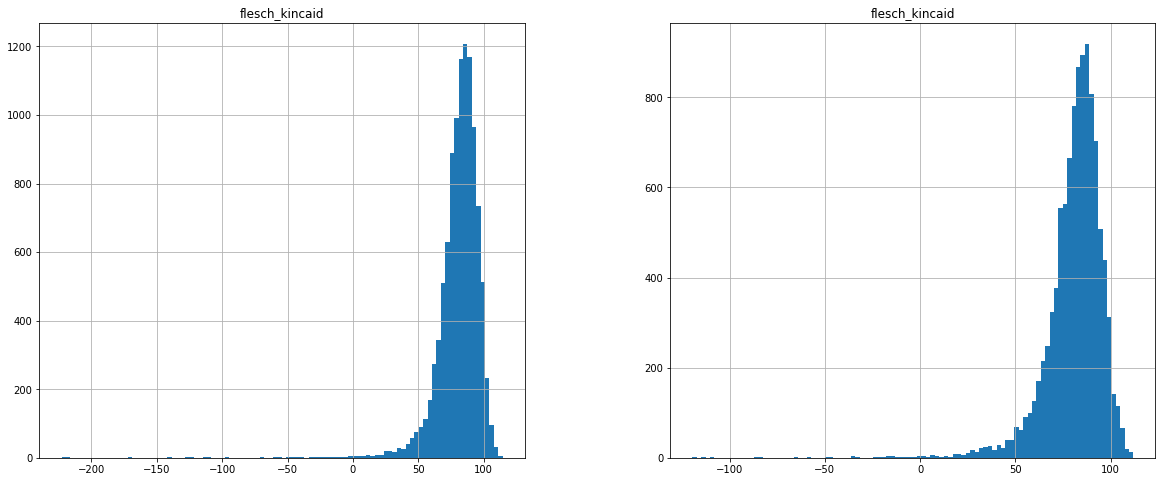

Real Data Avg FK score: 80.84
Fake Data Avg FK score: 80.84
Real Data Median FK score: 83.27
Fake Data Median FK score: 83.35
Real Data StDev FK score: 16.75
Fake Data StDev FK score: 15.4


In [26]:
#Looking for the Flesch-Kincaid Readability measure across our pipulation
data['word_count'] = data.apply(lambda row: len(row['tokenized_review']), axis=1)
data['sent_count'] = data.apply(lambda row: len(sent_tokenize(row['review_text'])), axis=1)
data['syll_count'] = data.apply(lambda row: len(list(flatten([dic.inserted(text).split('-') for text in row['tokenized_review']]))), axis=1)
data['flesch_kincaid'] = data.apply(lambda row: 206.835 - 1.015*row['word_count']/row['sent_count'] - 84.6*row['syll_count']/row['word_count'], axis=1)

real_data = data[data['label']== 'real'] 
fake_data = data[data['label']== 'fake'] 

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(20,8)

print('REAL vs FAKE F-K Score')
plt.title('Real Reviews')
real_data.hist('flesch_kincaid', bins=100, ax=axes[0])

plt.title('Fake Reviews')
fake_data.hist('flesch_kincaid', bins=100, ax=axes[1])

plt.show()

print('Real Data Avg FK score: ' + str(round(real_data['flesch_kincaid'].mean(axis=0), 2)))
print('Fake Data Avg FK score: ' + str(round(fake_data['flesch_kincaid'].mean(axis=0), 2)))

print('Real Data Median FK score: ' + str(round(real_data['flesch_kincaid'].median(axis=0), 2)))
print('Fake Data Median FK score: ' + str(round(fake_data['flesch_kincaid'].median(axis=0), 2)))

print('Real Data StDev FK score: ' + str(round(real_data['flesch_kincaid'].std(axis=0), 2)))
print('Fake Data StDev FK score: ' + str(round(fake_data['flesch_kincaid'].std(axis=0), 2)))

REAL vs FAKE number of stopwords
Real Data Avg stopwords: 40.91
Fake Data Avg stopwords: 31.49
Real Data Median stopwords: 24.0
Fake Data Median stopwords: 24.0
Real Data StDev stopwords: 54.08
Fake Data StDev stopwords: 30.23


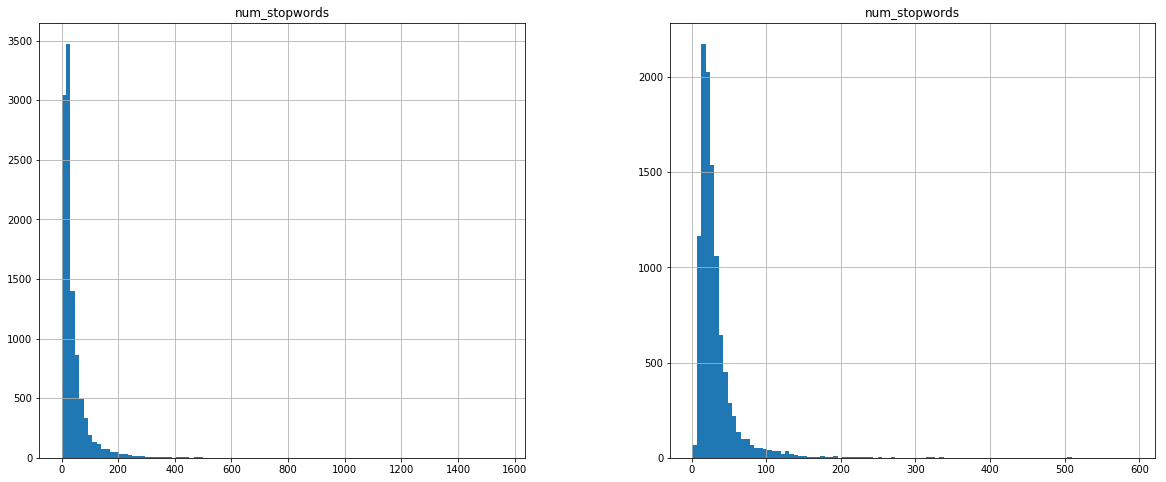

In [29]:
#What about stopwords?
real_data = data[data['label']== 'real'] 
fake_data = data[data['label']== 'fake'] 


fig, axes = plt.subplots(1, 2)
fig.set_size_inches(20,8)

print('REAL vs FAKE number of stopwords')
plt.title('Real Reviews')
real_data.hist('num_stopwords', bins=100, ax=axes[0])

plt.title('Fake Reviews')
fake_data.hist('num_stopwords', bins=100, ax=axes[1])

print('Real Data Avg stopwords: ' + str(round(real_data['num_stopwords'].mean(axis=0), 2)))
print('Fake Data Avg stopwords: ' + str(round(fake_data['num_stopwords'].mean(axis=0), 2)))

print('Real Data Median stopwords: ' + str(round(real_data['num_stopwords'].median(axis=0), 2)))
print('Fake Data Median stopwords: ' + str(round(fake_data['num_stopwords'].median(axis=0), 2)))

print('Real Data StDev stopwords: ' + str(round(real_data['num_stopwords'].std(axis=0), 2)))
print('Fake Data StDev stopwords: ' + str(round(fake_data['num_stopwords'].std(axis=0), 2)))